# Master thesis
# Integration of Environmental Risks and Environmental Stresses into the Own Risk and Solvency Assessment by Adapting the Solvency II Standard Formula

# Flood Risk

In [123]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from statistics import mean
from scipy.optimize import fsolve
import math
from math import log, exp
from csv import writer


In [124]:
# Importing Data
# data source
#    beta and correlation: (Jewson et al., 2023)
#    NUTS2: eurostat
data_beta = 'betas_mean_std.csv'
data_corr = 'betas_corrs.csv'
data_NUTS2 = 'NUTS2021.xlsx'

df_beta = pd.read_csv(data_beta, header=1)
df_corr = pd.read_csv(data_corr, header=1)
df_nuts = pd.read_excel(data_NUTS2, sheet_name=1, usecols = (0,3))

In [125]:
# remove irrelavent columns
del df_beta["Unnamed: 0"]
del df_beta["PIV_CODE"]
del df_beta["std"]

# rename columns
df_beta = df_beta.rename(columns={'COUNTRY_x': 'Country', 'NUTS_code_x': 'NUTS2', 'mean':'beta'})

#select subset of correlation matrix corresponding to regions of Germany
df_corr = df_corr.iloc[df_beta[df_beta["Country"] == "Germany"].index.tolist(), (df_beta[df_beta["Country"] == "Germany"].index+1).tolist()]

#select subset of beta values corresponding to regions of Germany
df_beta = df_beta[df_beta["Country"] == "Germany"]

# Country column is no longer needed
del df_beta["Country"]
df_beta

# correcting data error for one location in df_beta
df_beta = df_beta.replace('Dec-00','DEC0')

# rename column to match databases
df_nuts = df_nuts.rename(columns={'Code 2021': 'NUTS2'})
df_merge = pd.merge(df_beta, df_nuts, on ='NUTS2', how ='inner')

# check if all NUTS2 codes have been assigned corresponding names
print(df_beta.shape[0] == df_merge.shape[0])

# add Nuts-2 names to corr matrix
#df_corr.index = inner_join["NUTS level 2"]
df_corr.index = list(df_merge["NUTS level 2"])
df_corr.columns = list(df_merge["NUTS level 2"])

True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


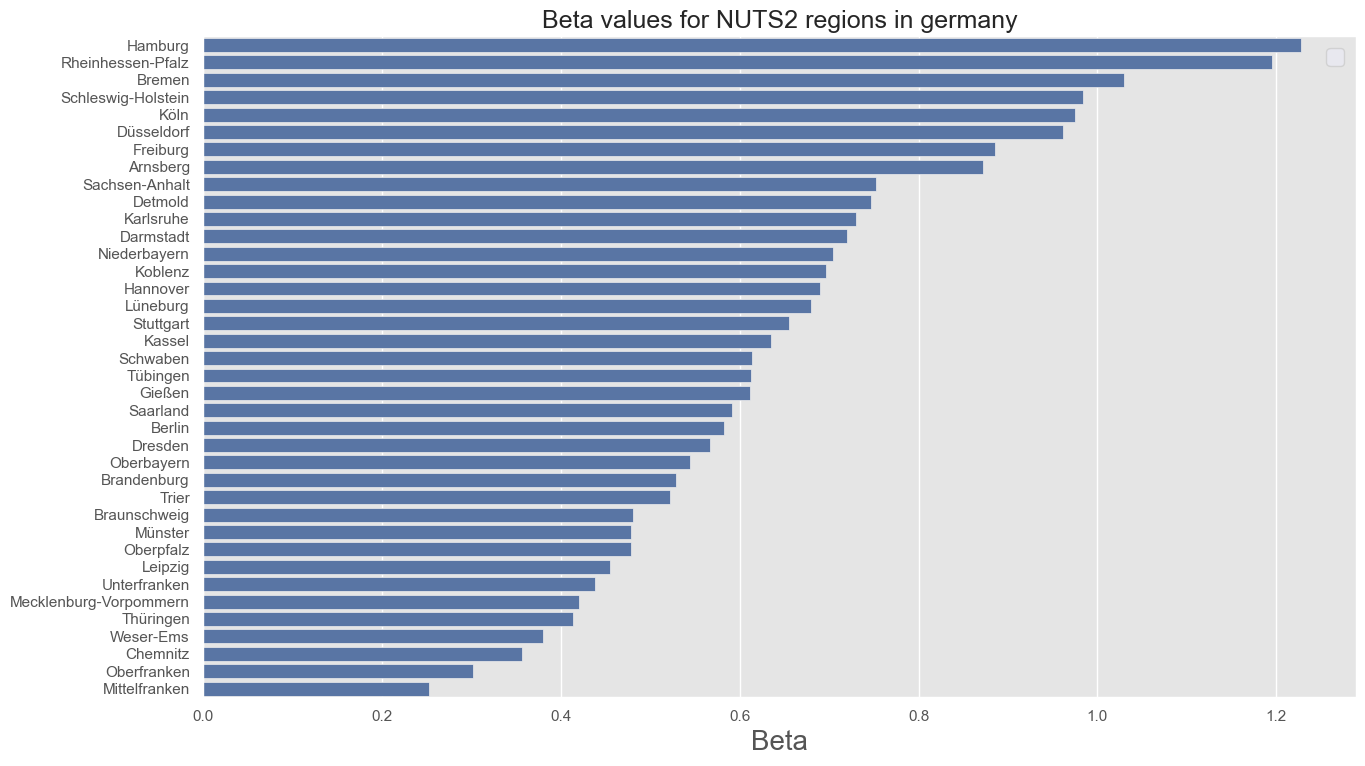

In [126]:
#df_beta
df_merge = df_merge.sort_values(['beta'],ascending=False).reset_index(drop=True)

from matplotlib import style
fig = plt.figure()
style.use("ggplot")
ax = sns.barplot(y= "NUTS level 2", x= "beta", data = df_merge, color = 'b')
sns.set(rc={'figure.figsize': (13.998,12)})
sns.set(font_scale=1.5)

plt.title("Beta values for NUTS2 regions in germany")
plt.ylabel(None)
plt.xlabel("Beta", fontsize=20)
plt.tight_layout()
plt.legend()
plt.savefig("Germany Betas.png", bbox_inches="tight") # save as png


In [127]:
# GMST data taken from NASA GISS (NASA 2022) for the period 1980-2022 and the future data (2023-2100) from CMIP5 projections same as in (Jewson et al., 2021)
Years = [1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,
           1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
           2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,
           2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,
           2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,
           2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,
           2094,2095,2096,2097,2098,2099,2100]

RCP26 = [0.26,0.32,0.14,0.31,0.15,0.12,0.18,0.32,0.39,0.27,0.45,0.40,0.22,0.23,0.31,0.44,0.33,0.46,0.60,
           0.38,0.39,0.53,0.62,0.61,0.53,0.67,0.63,0.66,0.54,0.65,0.72,0.61,0.65,0.67,0.74,0.89,1.01,0.92,
           0.85,0.97,1.01,0.84,0.89,1.034314286,1.009714286,1.020014286,1.040914286,1.068614286,1.072114286,
           1.095114286,1.100414286,1.099014286,1.118514286,1.133414286,1.135314286,1.168814286,1.200414286,
           1.205414286,1.227214286,1.212614286,1.243014286,1.270114286,1.250114286,1.254514286,1.265814286,
           1.263314286,1.294714286,1.289814286,1.314214286,1.322514286,1.315614286,1.276314286,1.302414286,
           1.318414286,1.312014286,1.317914286,1.341214286,1.297414286,1.308514286,1.314614286,1.327814286,
           1.335814286,1.331214286,1.318014286,1.289714286,1.334414286,1.323914286,1.316614286,1.300214286,
           1.302414286,1.303114286,1.311014286,1.283914286,1.293814286,1.296914286,1.316614286,1.306314286,
           1.290614286,1.288814286,1.272114286,1.264614286,1.262514286,1.290514286,1.285114286,1.267214286,
           1.267414286,1.294314286,1.315614286,1.310314286,1.283914286,1.296614286,1.281214286,1.301014286,
           1.300114286,1.303114286,1.286714286,1.297514286,1.312114286,1.276714286,1.281414286,1.276414286]

RCP45 = [0.26,0.32,0.14,0.31,0.15,0.12,0.18,0.32,0.39,0.27,0.45,0.40,0.22,0.23,0.31,0.44,0.33,0.46,0.60,
           0.38,0.39,0.53,0.62,0.61,0.53,0.67,0.63,0.66,0.54,0.65,0.72,0.61,0.65,0.67,0.74,0.89,1.01,0.92,
           0.85,0.97,1.01,0.84,0.89,0.997892857,1.048392857,1.068092857,1.104792857,1.122192857,1.125792857,
           1.156292857,1.160992857,1.201692857,1.234692857,1.255392857,1.274392857,1.283792857,1.319992857,
           1.369992857,1.385592857,1.380892857,1.415092857,1.439892857,1.457092857,1.493592857,1.520292857,
           1.517692857,1.538092857,1.577192857,1.575492857,1.620392857,1.657092857,1.673492857,1.669992857,
           1.706292857,1.707892857,1.758592857,1.739492857,1.740192857,1.797792857,1.839292857,1.865392857,
           1.857692857,1.864092857,1.881192857,1.907592857,1.918492857,1.933992857,1.929392857,1.931192857,
           1.942492857,1.985592857,1.997392857,2.000992857,2.028692857,2.016192857,2.020792857,2.032892857,
           2.057492857,2.092092857,2.106292857,2.117492857,2.123492857,2.121092857,2.096892857,2.126892857,
           2.131292857,2.144892857,2.124092857,2.134492857,2.171392857,2.163692857,2.144092857,2.145092857,
           2.128992857,2.129992857,2.169192857,2.186492857,2.181092857,2.217592857,2.210492857,2.223692857]

RCP60 = [0.26,0.32,0.14,0.31,0.15,0.12,0.18,0.32,0.39,0.27,0.45,0.40,0.22,0.23,0.31,0.44,0.33,0.46,0.60,
           0.38,0.39,0.53,0.62,0.61,0.53,0.67,0.63,0.66,0.54,0.65,0.72,0.61,0.65,0.67,0.74,0.89,1.01,0.92,
           0.85,0.97,1.01,0.84,0.89,0.942414286,0.957814286,1.000414286,1.023114286,1.053414286,1.090814286,
           1.073014286,1.058114286,1.117514286,1.123714286,1.123814286,1.177514286,1.190814286,1.187514286,
           1.223514286,1.261714286,1.289014286,1.276414286,1.339114286,1.365714286,1.375314286,1.402214286,
           1.399914286,1.437314286,1.464914286,1.479114286,1.505514286,1.509614286,1.539814286,1.558214286,
           1.595014286,1.637114286,1.653414286,1.636714286,1.652214286,1.701014286,1.731114286,1.759214286,
           1.782114286,1.811014286,1.801714286,1.823014286,1.842914286,1.913014286,1.943114286,1.977514286,
           1.982014286,2.007114286,2.066314286,2.079214286,2.126014286,2.147314286,2.174914286,2.184414286,
           2.218514286,2.261514286,2.309614286,2.328014286,2.347014286,2.369414286,2.396614286,2.452014286,
           2.473314286,2.486514286,2.497914286,2.518014286,2.561814286,2.613014286,2.626814286,2.585914286,
           2.614614286,2.644714286,2.688414286,2.688514286,2.685314286,2.724614286,2.746214286,2.773814286]

RCP85 = [0.26,0.32,0.14,0.31,0.15,0.12,0.18,0.32,0.39,0.27,0.45,0.40,0.22,0.23,0.31,0.44,0.33,0.46,0.60,
           0.38,0.39,0.53,0.62,0.61,0.53,0.67,0.63,0.66,0.54,0.65,0.72,0.61,0.65,0.67,0.74,0.89,1.01,0.92,
           0.85,0.97,1.01,0.84,0.89,1.049564286,1.070264286,1.126564286,1.195464286,1.215064286,1.246964286,
           1.272564286,1.262464286,1.293464286,1.340864286,1.391164286,1.428764286,1.452564286,1.494164286,
           1.520664286,1.557164286,1.633664286,1.654264286,1.693264286,1.730264286,1.795264286,1.824264286,
           1.823864286,1.880664286,1.952864286,1.991764286,1.994764286,2.085764286,2.105764286,2.155064286,
           2.227464286,2.249964286,2.313664286,2.341464286,2.394064286,2.457364286,2.484664286,2.549564286,
           2.605964286,2.656864286,2.707364286,2.742964286,2.789764286,2.847664286,2.903564286,2.925064286,
           2.962864286,3.002664286,3.069264286,3.133364286,3.174764286,3.217764286,3.256564286,3.306864286,
           3.375464286,3.420264286,3.476464286,3.493864286,3.552964286,3.592364286,3.630664286,3.672464286,
           3.734364286,3.789764286,3.838164286,3.882264286,3.936064286,3.984064286,4.055764286,4.098964286,
           4.122364286,4.172064286,4.225264286,4.275064286,4.339064286,4.375864286,4.408064286,4.477764286]


In [128]:
df_gmst = pd.DataFrame(np.array([RCP26, RCP45, RCP60, RCP85]).T,
                   columns = ['RCP26','RCP45','RCP60','RCP85'], index = Years)


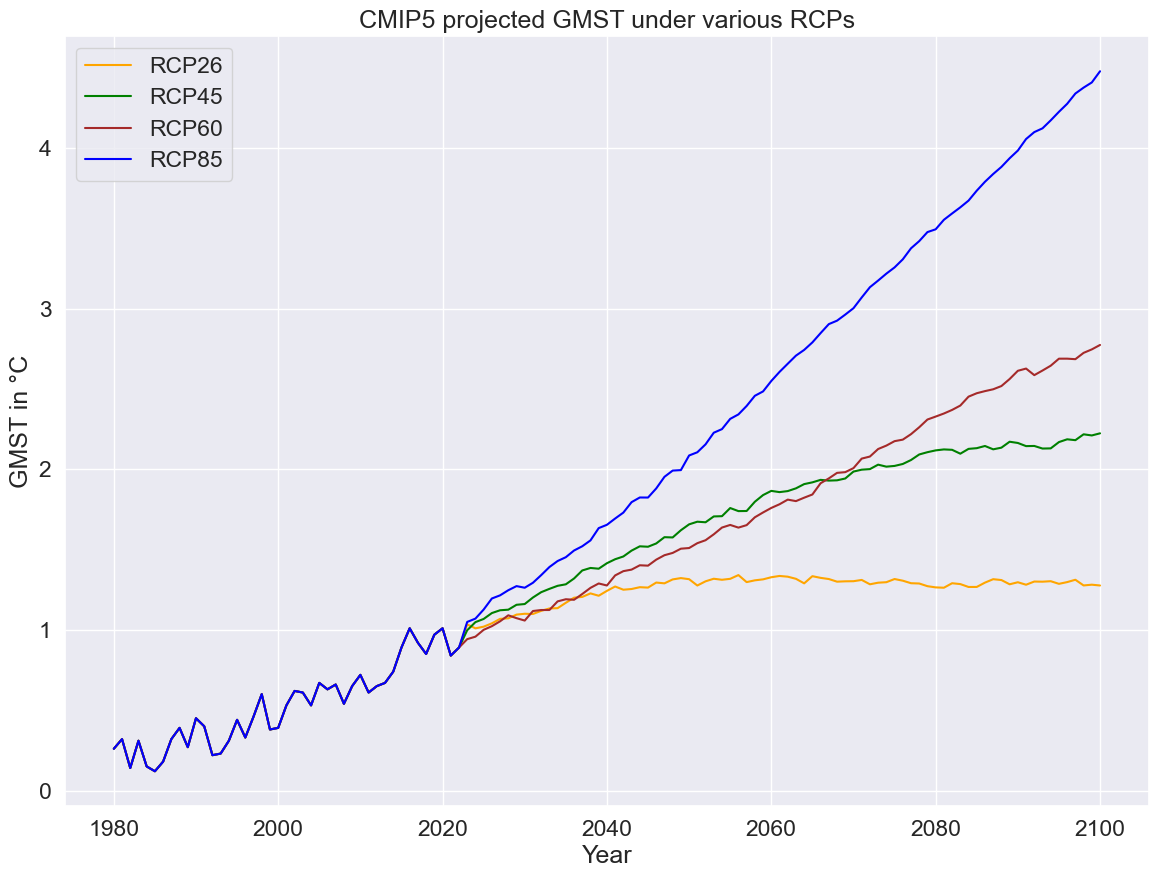

In [129]:
# code 
# Visualizing The GMST for all the scenarios 
  
# to set the plot size 
plt.figure(figsize=(13.998, 10)) 

# using plot method to plot gmst. 
# in plot method we set the label and color of the curve. 
df_gmst['RCP26'].plot(label='RCP26', color='orange') 
df_gmst['RCP45'].plot(label='RCP45', color='green') 
df_gmst['RCP60'].plot(label='RCP60', color='brown') 
df_gmst['RCP85'].plot(label='RCP85', color='blue') 
  
# adding title to the plot 
plt.title('CMIP5 projected GMST under various RCPs') 
  
# adding Label to the axis 
plt.xlabel('Year') 
plt.ylabel('GMST in °C')

# adding grid to the curve 
plt.grid(True)  
# adding legend to the curve 
plt.legend() 
plt.savefig("GMST.png", bbox_inches="tight") # save as png

In [130]:
# Calculating GMST for baseline period
T_baseline = np.mean(df_gmst['RCP26'][0:21])
T_baseline

0.3176190476190476

In [131]:
# Calculating delta GMST
df_delta_gmst = df_gmst - T_baseline

In [132]:
# Defining Function to calculate risk changes between two periods for a given GMST ts
def delta_risk(GMST, t_0,t,beta):
    delta_r = np.exp(beta*(GMST[t]-GMST[t_0]))-1
    return delta_r


In [133]:
# Calculating risk increases for 2030 and 2040 under rcp45
t_0 = 2022
t_1 = 2030
t_2 = 2040
df_merge["2030_rcp45"] = delta_risk(df_delta_gmst['RCP45'], t_0, t_1, df_merge["beta"])
df_merge["2040_rcp45"] = delta_risk(df_delta_gmst['RCP45'], t_0, t_2, df_merge["beta"])


C:\Users\4727\AppData\Local\Temp\ipykernel_9184\2395113000.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tidy["Nuts Level 2"].unique().astype(str), rotation='vertical')


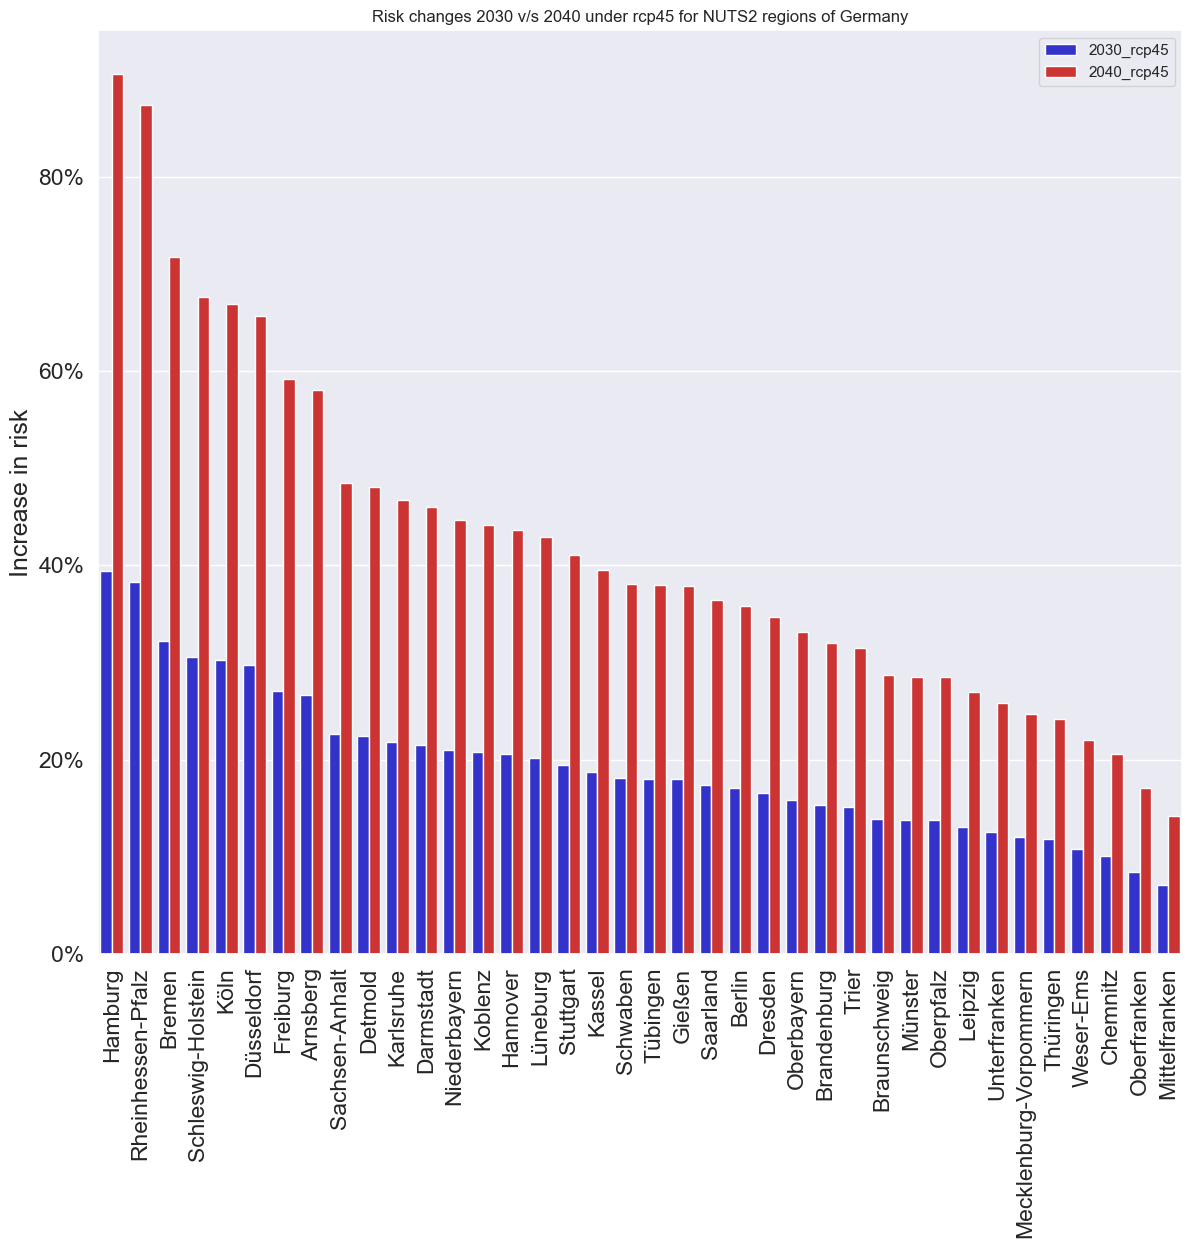

In [134]:
# Plotting risk increases for 2030 and 2040
df = df_merge[["NUTS level 2","2030_rcp45", "2040_rcp45"]]
tidy = df.melt(id_vars='NUTS level 2').rename(columns=str.title)

ax = sns.barplot(data=tidy, x="Nuts Level 2", y='Value', hue='Variable', palette=['blue', 'red'], saturation=0.6)
sns.set(rc={'figure.figsize': (13.998,6)})
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('Risk changes 2030 v/s 2040 under rcp45 for NUTS2 regions of Germany')
ax.set_ylabel('Increase in risk')
ax.set_xlabel(None)
ax.set_xticklabels(tidy["Nuts Level 2"].unique().astype(str), rotation='vertical')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Ask Matplotlib to show it
plt.savefig("AAL_2030_v_2040.png", bbox_inches="tight") # save as png
plt.show()


In [135]:
# Defining Function to solve the linear optimisation problem

def equations(p):
    x, k = p
    return (x*k/(k-1)-mean, (x/quantile)**k - 0.005)

In [136]:
# Calculating SCR increases for 2030 and 2040 under rcp45
#t_0 = 2022
#t_1 = 2030
#t_2 = 2040

# Values for existing risk profile as at year 2022
# Mean value of annual flood loss = 2 million
# 99.5% value = 15 million

#Extracting parameter values for the year 2022
mean = 2
quantile = 15
x, k =  fsolve(equations, (1, 2))

# New k parameter value for each year keeping x constant
df_merge["2030_rcp45_k"] = (1+df_merge["2030_rcp45"])*mean / ((1+df_merge["2030_rcp45"])*mean - x)
df_merge["2040_rcp45_k"] = (1+df_merge["2040_rcp45"])*mean / ((1+df_merge["2040_rcp45"])*mean - x)

#SCR
df_merge["2030_rcp45_SCR"] = x/(0.005)**(1/df_merge["2030_rcp45_k"])
df_merge["2040_rcp45_SCR"] = x/(0.005)**(1/df_merge["2040_rcp45_k"])

#scr changes
df_merge["2030_rcp45_SCR_increase"] = df_merge["2030_rcp45_SCR"]/quantile - 1
df_merge["2040_rcp45_SCR_increase"] = df_merge["2040_rcp45_SCR"]/quantile - 1



C:\Users\4727\AppData\Local\Temp\ipykernel_9184\2065659962.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tidy["Nuts Level 2"].unique().astype(str), rotation='vertical')


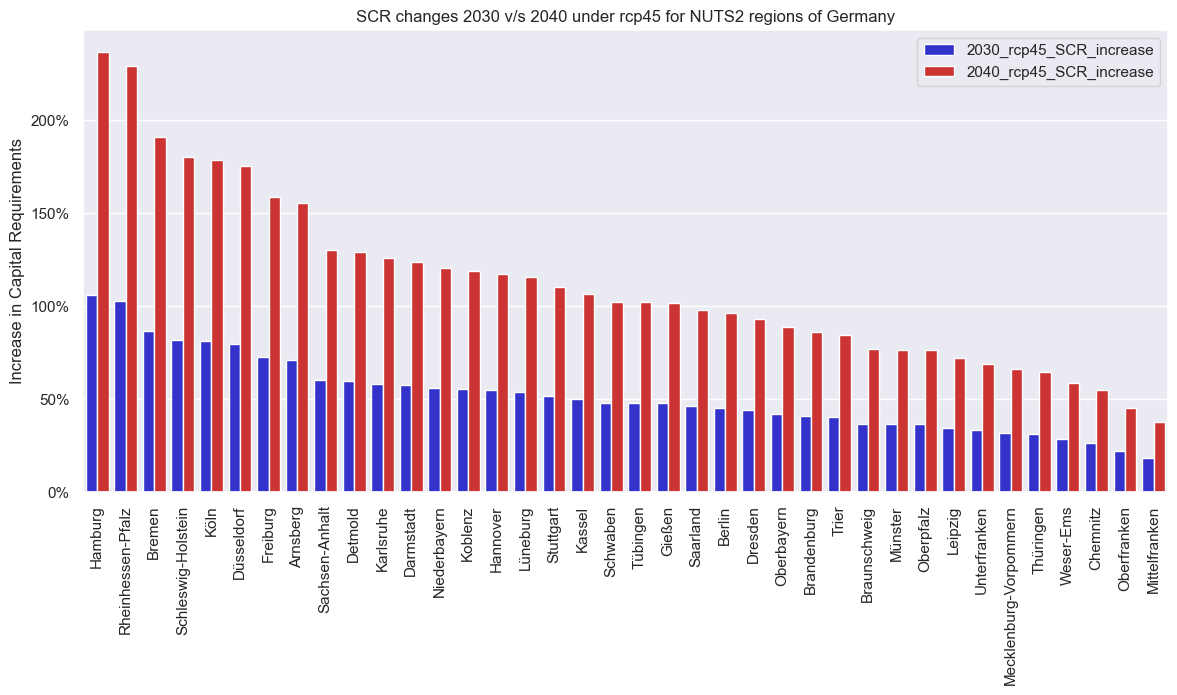

In [137]:
# Plotting SCR increases for 2030 and 2040 under rcp45
sns.set()
plt.figure()
df = df_merge[["NUTS level 2","2030_rcp45_SCR_increase", "2040_rcp45_SCR_increase"]]
tidy = df.melt(id_vars='NUTS level 2').rename(columns=str.title)

ax = sns.barplot(data=tidy, x="Nuts Level 2", y='Value', hue='Variable', palette=['blue', 'red'], saturation=0.6)
sns.set(rc={'figure.figsize': (13.998,6)})
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('SCR changes 2030 v/s 2040 under rcp45 for NUTS2 regions of Germany')
#ax.grid(color='#cccccc')
ax.set_ylabel('Increase in Capital Requirements')
ax.set_xlabel(None)
ax.set_xticklabels(tidy["Nuts Level 2"].unique().astype(str), rotation='vertical')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Ask Matplotlib to show it
plt.savefig("SCR_2030_v_2040.png", bbox_inches="tight") # save as png
plt.show()


In [138]:
# Average Germany beta (simple average of betas from all regions of Germany)
# Calculating corresponding risk changes for the future years
t_0 = 2022
beta = np.mean(df_merge[["beta"]])

df_new = df_delta_gmst.copy()
df_new["RCP26"] = delta_risk(df_delta_gmst['RCP26'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP45"] = delta_risk(df_delta_gmst['RCP45'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP60"] = delta_risk(df_delta_gmst['RCP60'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP85"] = delta_risk(df_delta_gmst['RCP85'], t_0, df_delta_gmst.index.to_series(), beta)
df_new = df_new.loc['2022':'2050']


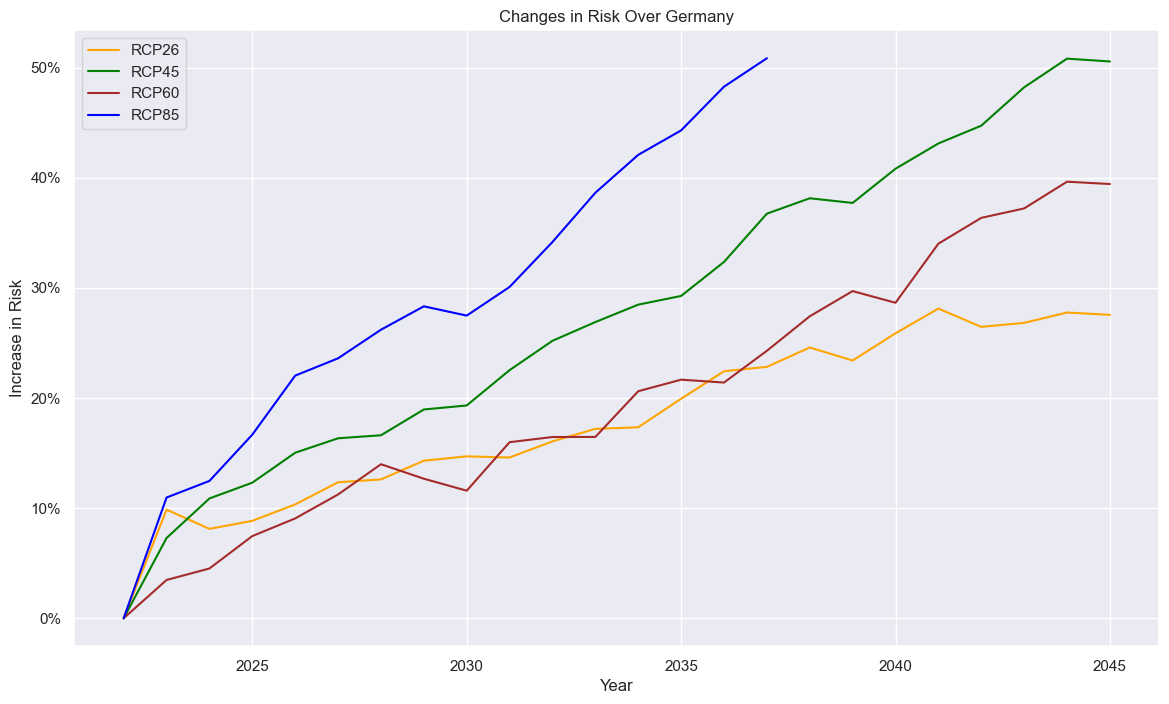

In [139]:
# Average beta for Germany, risk changes
# Visualizing risk changes for Germany under all the scenarios 

# to set the plot size 
plt.figure(figsize=(13.998, 8)) 

# using plot method to plot risk increases. 
# in plot method we set the label and color of the curve. 
df_new['RCP26'].loc['2022':'2045'].plot(label='RCP26', color='orange') 
df_new['RCP45'].loc['2022':'2045'].plot(label='RCP45', color='green') 
df_new['RCP60'].loc['2022':'2045'].plot(label='RCP60', color='brown') 
df_new['RCP85'].loc['2022':'2037'].plot(label='RCP85', color='blue') 

# percentage values
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# adding title to the plot 
plt.title('Changes in Risk Over Germany') 
  
# adding Label to the x-axis 
plt.xlabel('Year') 
plt.ylabel('Increase in Risk')

# adding grid to the curve 
plt.grid(True)  
# adding legend to the curve 
plt.legend()

# Ask Matplotlib to show it
plt.savefig("Average_Germany.png", bbox_inches="tight") # save as png
plt.show()


## Single location

In [140]:
# assumption: x remains constant, extract k for each future year
# stuttgart 

# sample known potfolio values for present year
# Region = Stuttgart
# year = 2022
# Exposure = 2000 million
# Expected mean loss = 1.5 million
# SCR = 11 million

# Stuttgart beta
t_0 = 2022
mean = 1.5
quantile = 11

beta = df_merge[df_merge["NUTS level 2"].isin(["Stuttgart"])]["beta"].values.tolist()
x, k =  fsolve(equations, (1, 2))


df_new = df_delta_gmst.copy()
df_new["RCP26"] = delta_risk(df_delta_gmst['RCP26'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP45"] = delta_risk(df_delta_gmst['RCP45'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP60"] = delta_risk(df_delta_gmst['RCP60'], t_0, df_delta_gmst.index.to_series(), beta)
df_new["RCP85"] = delta_risk(df_delta_gmst['RCP85'], t_0, df_delta_gmst.index.to_series(), beta)
df_new = df_new.loc['2022':'2050']

In [141]:
# Calculating SCR increases in both short and long term scenarios for ORSA
year_list = [2022,2023,2024,2025,2030,2032,2037,2045,2050]

df_k_param = df_new.copy()
df_k_param["RCP26"] = (1+df_new['RCP26'])*mean / ((1+df_new['RCP26'])*mean - x)
df_k_param["RCP45"] = (1+df_new['RCP45'])*mean / ((1+df_new['RCP45'])*mean - x)
df_k_param["RCP60"] = (1+df_new['RCP60'])*mean / ((1+df_new['RCP60'])*mean - x)
df_k_param["RCP85"] = (1+df_new['RCP85'])*mean / ((1+df_new['RCP85'])*mean - x)

df_SCR = x/(0.005)**(1/df_k_param)
df_SCR_change = df_SCR/quantile - 1
df_SCR_change = df_SCR_change.loc[year_list]
df_SCR_change = df_SCR_change.mul(100).round(0).astype(str).add(' %')
df_SCR_change

,RCP26,RCP45,RCP60,RCP85
2022,0.0 %,0.0 %,0.0 %,0.0 %
2023,26.0 %,19.0 %,9.0 %,29.0 %
2024,22.0 %,29.0 %,12.0 %,33.0 %
2025,24.0 %,33.0 %,20.0 %,45.0 %
2030,40.0 %,52.0 %,31.0 %,75.0 %
2032,43.0 %,69.0 %,44.0 %,94.0 %
2037,62.0 %,101.0 %,66.0 %,140.0 %
2045,75.0 %,140.0 %,109.0 %,227.0 %
2050,88.0 %,178.0 %,137.0 %,309.0 %


## Multiple locations

In [142]:
# sample known potfolio values for present year

# region, year, peril, exposure, mean, scr
#Hamburg, 2022, Flood, 1200, 0.90, 6.69
#Bremen, 2022, Flood, 400, 0.32, 2.55
#Leipzig, 2022, Flood, 200, 0.17, 1.36
#Oberfranken, 2022, Flood, 350, 0.33, 2.50
#Köln, 2022, Flood, 700, 0.75, 5.86
#Niederbayern, 2022, Flood, 150, 0.15, 1.16
#Düsseldorf, 2022, Flood, 250, 0.25, 2.03
#Koblenz, 2022, Flood, 200, 0.20, 1.68

df_germany = pd.DataFrame(np.array([["Hamburg", 2022, "Flood", 1200, 0.90, 6.69],
                             ["Bremen", 2022, "Flood", 400, 0.32, 2.55],
                             ["Leipzig", 2022, "Flood", 200, 0.27, 2.46],
                             ["Oberfranken", 2022, "Flood", 350, 0.33, 2.50],
                             ["Köln", 2022, "Flood", 700, 0.75, 5.86],
                             ["Niederbayern", 2022, "Flood", 150, 0.21, 1.75],
                             ["Düsseldorf", 2022, "Flood", 250, 0.25, 2.03],
                             ["Koblenz", 2022, "Flood", 200, 0.20, 1.68]]),
                   columns=['Location','Year','Peril','Exposure', 'Old_Mean', 'Old_SCR'])

df_germany = pd.merge(left=df_germany, right=df_merge[["NUTS level 2","beta"]], left_on='Location', right_on='NUTS level 2', how='left')
del df_germany["NUTS level 2"]
df_germany['Old_Mean'] = df_germany['Old_Mean'].astype(float)
df_germany['Old_SCR'] = df_germany['Old_SCR'].astype(float)
df_germany['beta'] = df_germany['beta'].astype(float)


In [143]:
# Calculating x and k parameter values for present year
df_list_x = list()
df_list_k = list()

for mean, quantile in zip(df_germany["Old_Mean"],df_germany["Old_SCR"]):
    mean = mean
    quantile = quantile
    a = fsolve(equations, (1, 2))[0]
    b = fsolve(equations, (1, 2))[1]
    df_list_x.append(a)
    df_list_k.append(b)
df_germany["x"] = df_list_x
df_germany["k_2022"] = df_list_k

C:\Users\4727\AppData\Local\Temp\ipykernel_9184\4055718197.py:5: RuntimeWarning: invalid value encountered in scalar power
  return (x*k/(k-1)-mean, (x/quantile)**k - 0.005)


In [144]:
# Calculating SCR increases for each of locations in sample portfolio independently using its current mean and scr values
t_0 = 2022
df_new_collection = {}

for beta, Location, mean, quantile, x in zip(df_germany["beta"],df_germany["Location"],df_germany["Old_Mean"],df_germany["Old_SCR"],df_germany["x"]):
    beta = beta
    df_new = df_delta_gmst.copy()
    df_new["RCP26"] = delta_risk(df_delta_gmst['RCP26'], t_0, df_delta_gmst.index.to_series(), beta)
    df_new["RCP45"] = delta_risk(df_delta_gmst['RCP45'], t_0, df_delta_gmst.index.to_series(), beta)
    df_new["RCP60"] = delta_risk(df_delta_gmst['RCP60'], t_0, df_delta_gmst.index.to_series(), beta)
    df_new["RCP85"] = delta_risk(df_delta_gmst['RCP85'], t_0, df_delta_gmst.index.to_series(), beta)
    df_new = df_new.loc['2022':'2050']
    df_k_param = df_new.copy()
    df_k_param["RCP26"] = (1+df_new['RCP26'])*mean / ((1+df_new['RCP26'])*mean - x)
    df_k_param["RCP45"] = (1+df_new['RCP45'])*mean / ((1+df_new['RCP45'])*mean - x)
    df_k_param["RCP60"] = (1+df_new['RCP60'])*mean / ((1+df_new['RCP60'])*mean - x)
    df_k_param["RCP85"] = (1+df_new['RCP85'])*mean / ((1+df_new['RCP85'])*mean - x)
    df_SCR = x/(0.005)**(1/df_k_param)
    df_SCR_change = df_SCR/quantile - 1
    df_new_collection[Location] = df_SCR

In [145]:
#correlation matrix for locations in the sample portfolio
L1 = df_germany["Location"].tolist()
df_corr_multiple = df_corr.loc[L1][L1]
df_corr_multiple

,Hamburg,Bremen,Leipzig,Oberfranken,Köln,Niederbayern,Düsseldorf,Koblenz
Hamburg,1.000000,0.666638,0.432875,0.570813,0.343624,0.471748,0.415842,0.164715
Bremen,0.666638,1.000000,0.737449,0.751018,0.744176,0.418669,0.759908,0.677078
Leipzig,0.432875,0.737449,1.000000,0.784438,0.505609,0.716756,0.472188,0.451498
Oberfranken,0.570813,0.751018,0.784438,1.000000,0.676309,0.793184,0.580429,0.608231
Köln,0.343624,0.744176,0.505609,0.676309,1.000000,0.447386,0.974951,0.973820
Niederbayern,0.471748,0.418669,0.716756,0.793184,0.447386,1.000000,0.399716,0.330093
Düsseldorf,0.415842,0.759908,0.472188,0.580429,0.974951,0.399716,1.000000,0.927086
Koblenz,0.164715,0.677078,0.451498,0.608231,0.973820,0.330093,0.927086,1.000000


In [146]:
# Getting correlation matrix structure in the same format as under SF
df_corr_multiple = df_corr_multiple.mask((1-np.tril(np.ones(df_corr_multiple.shape))).astype(bool))
df_corr_multiple = df_corr_multiple.stack().reset_index()

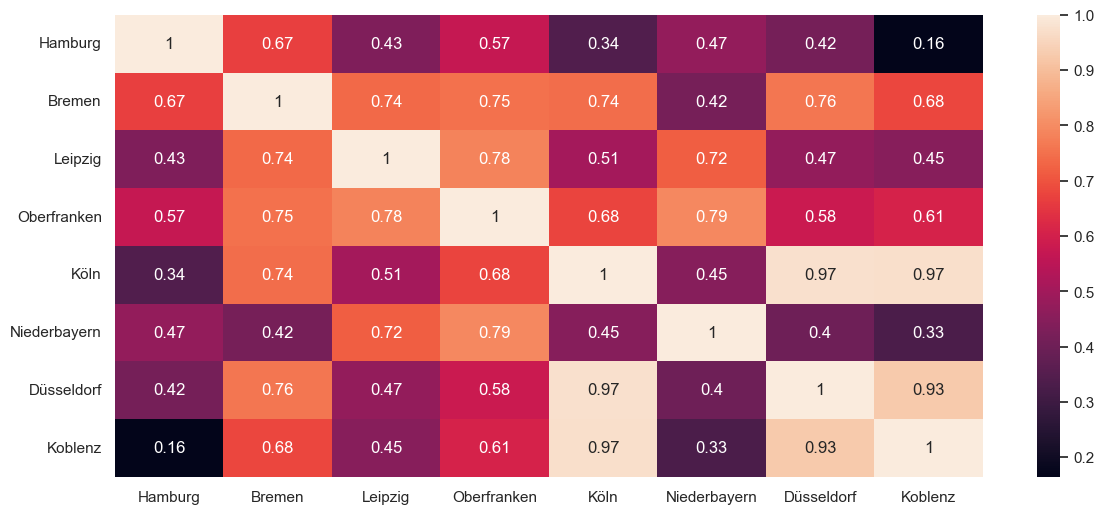

In [147]:
# Visualising the correlation matrix
df_corr_visual = df_corr.loc[L1][L1]
sns.heatmap(df_corr_visual, annot = True)
plt.savefig("Correlation.png") # save as png
plt.show()

In [148]:
# Calculating SCR increases for the entire portfolio in both short and long term scenarios for ORSA
year_list = [2022,2023,2024,2025,2030,2032,2037,2045,2050]
RCP_list = ["RCP26","RCP45","RCP60","RCP85"]
Location_list = df_germany["Location"].to_list()
df_portfolio =pd.DataFrame(index=RCP_list)
for year in year_list:
    my_list = []
    for RCP in RCP_list:
        total = 0
        for Location1, Location2, corr in zip(df_corr_multiple["level_0"], df_corr_multiple["level_1"], df_corr_multiple[0]):
            total += df_new_collection[Location1][RCP][year]*df_new_collection[Location2][RCP][year]*corr
        my_list.append(np.sqrt(total))
    df_portfolio[year] = my_list
df_portfolio= df_portfolio.T

# SCR changes
df_portfolio = df_portfolio.apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100).round(0).astype(str).add(' %'))
df_portfolio

,RCP26,RCP45,RCP60,RCP85
2022,0.0 %,0.0 %,0.0 %,0.0 %
2023,37.0 %,27.0 %,12.0 %,41.0 %
2024,30.0 %,40.0 %,16.0 %,47.0 %
2025,33.0 %,46.0 %,27.0 %,64.0 %
2030,56.0 %,74.0 %,43.0 %,108.0 %
2032,61.0 %,99.0 %,63.0 %,136.0 %
2037,89.0 %,147.0 %,95.0 %,205.0 %
2045,109.0 %,204.0 %,158.0 %,328.0 %
2050,127.0 %,260.0 %,201.0 %,432.0 %


# Hail Risk

## Linear increase in frequency

In [149]:
# Taking values of changes in frequencies from (Raupach et al., 2021 and Rädler et. al, 2019).
delta_r_rcp45 = 0.35
delta_r_rcp85 = 0.93

# sample known potfolio values for present year
# year = 2022
# Expected mean loss = 2 million
# SCR = 15 million

mean = 2
quantile = 15
t_0 = 2022
t_n = 2100
T = t_n - t_0

# parameter computation
x, k =  fsolve(equations, (1, 2))

Years = [2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,
         2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,
         2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,
         2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,
         2098,2099,2100]

df_hail = pd.DataFrame(columns = ['delta_t'],index = Years)
df_hail["delta_t"] = range(T+1)
df_hail["rcp45_k"] = (1+df_hail["delta_t"]*delta_r_rcp45/T)*mean / ((1+df_hail["delta_t"]*delta_r_rcp45/T)*mean - x)
df_hail["rcp85_k"] = (1+df_hail["delta_t"]*delta_r_rcp85/T)*mean / ((1+df_hail["delta_t"]*delta_r_rcp85/T)*mean - x)

#scr
df_hail["rcp45_SCR"] = x/(0.005)**(1/df_hail["rcp45_k"])
df_hail["rcp85_SCR"] = x/(0.005)**(1/df_hail["rcp85_k"])
df_hail["rcp45_SCR_change"] = df_hail["rcp45_SCR"]/quantile - 1
df_hail["rcp85_SCR_change"] = df_hail["rcp85_SCR"]/quantile - 1

# For visualisation
index_values = [2023,2024,2025,2030,2032,2045,2050,2100]
df_hail_plot = df_hail.loc[index_values][["rcp45_SCR_change", "rcp85_SCR_change"]]
df_hail_plot["Year"] = index_values

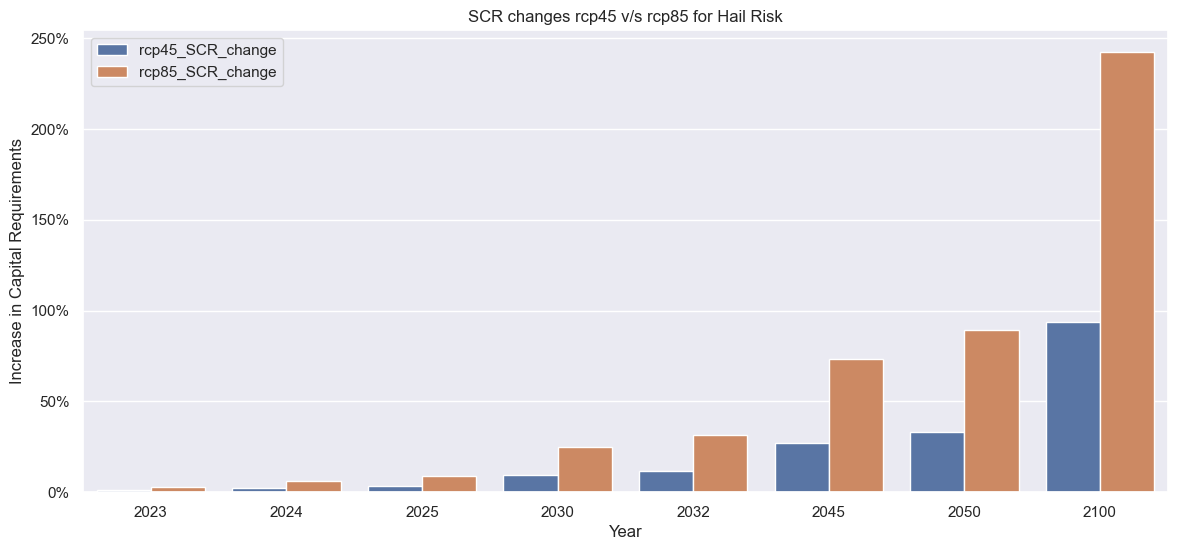

In [150]:
# Visualisation
tidy = df_hail_plot.melt(id_vars='Year').rename(columns=str.title)
tidy
ax = sns.barplot(tidy, x='Year', y='Value', hue='Variable')
sns.set(rc={'figure.figsize': (13.998,8)})
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('SCR changes rcp45 v/s rcp85 for Hail Risk')
ax.set_ylabel('Increase in Capital Requirements')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.savefig("SCR_Hail.png", bbox_inches="tight") # save as png

## Exponential increase in frequency

In [154]:
# Taking values of changes in frequencies from (Raupach et al., 2021 and Rädler et. al, 2019)
delta_r_rcp45 = 0.35
delta_r_rcp85 = 0.93

# sample known potfolio values for present year
# year = 2022
# Expected mean loss = 2 million
# SCR = 15 million

t_0 = 2022
t_n = 2100
T = t_n - t_0

delta_r_rcp45 = 0.35 # for delta_t = T
delta_r_rcp85 = 0.93 # for delta_t = T

# annual rate of increase in risk
r_rcp45 = np.power(1+delta_r_rcp45, 1/T) - 1
r_rcp85 = np.power(1+delta_r_rcp85, 1/T) - 1

#parameter values
mean = 2
quantile = 15

# parameter computation
x, k =  fsolve(equations, (1, 2))

Years = [2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,
         2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,
         2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,
         2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,
         2098,2099,2100]

df_hail = pd.DataFrame(columns = ['delta_t'],index = Years)
df_hail["delta_t"] = range(T+1)


df_hail["delta_r_rcp45"] = np.power(1+r_rcp45, df_hail["delta_t"])-1
df_hail["delta_r_rcp85"] = np.power(1+r_rcp85, df_hail["delta_t"])-1

df_hail["rcp45_k"] = (1+df_hail["delta_r_rcp45"])*mean / ((1+df_hail["delta_r_rcp45"])*mean - x)
df_hail["rcp85_k"] = (1+df_hail["delta_r_rcp85"])*mean / ((1+df_hail["delta_r_rcp85"])*mean - x)

#df_hail["rcp45_k"] = (1+df_hail["delta_t"]*delta_r_rcp45/T)*mean / ((1+df_hail["delta_t"]*delta_r_rcp45/T)*mean - x)
#df_hail["rcp85_k"] = (1+df_hail["delta_t"]*delta_r_rcp85/T)*mean / ((1+df_hail["delta_t"]*delta_r_rcp85/T)*mean - x)

#scr
df_hail["rcp45_SCR"] = x/(0.005)**(1/df_hail["rcp45_k"])
df_hail["rcp85_SCR"] = x/(0.005)**(1/df_hail["rcp85_k"])
df_hail["rcp45_SCR_change"] = df_hail["rcp45_SCR"]/quantile - 1
df_hail["rcp85_SCR_change"] = df_hail["rcp85_SCR"]/quantile - 1

# For visualisation
index_values = [2023,2024,2025,2030,2032,2045,2050,2100]
df_hail_plot = df_hail.loc[index_values][["rcp45_SCR_change", "rcp85_SCR_change"]]
df_hail_plot["Year"] = index_values

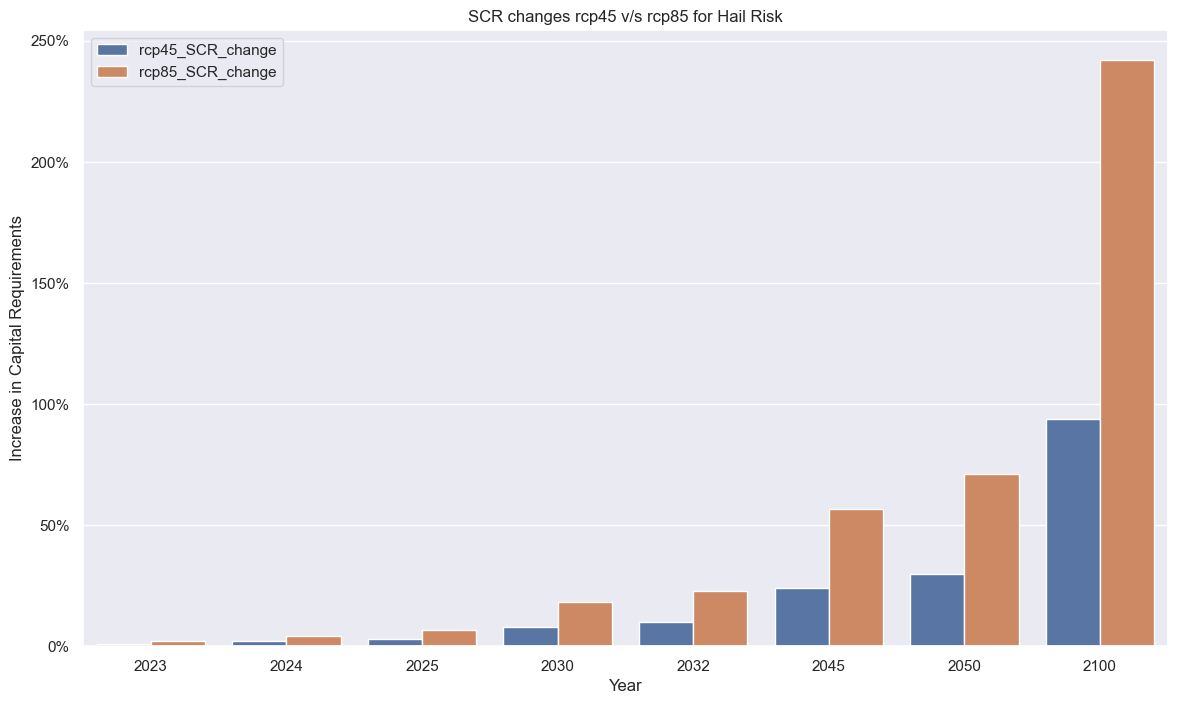

In [153]:
# Visualisation
tidy = df_hail_plot.melt(id_vars='Year').rename(columns=str.title)
tidy
ax = sns.barplot(tidy, x='Year', y='Value', hue='Variable')
sns.set(rc={'figure.figsize': (13.998,8)})
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('SCR changes rcp45 v/s rcp85 for Hail Risk')
ax.set_ylabel('Increase in Capital Requirements')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

plt.savefig("SCR_Hail_exponential.png", bbox_inches="tight") # save as png